In [5]:
import startup

import os
import logging
import argparse
import numpy as np
import torch
from omegaconf import OmegaConf

from models.factory import dataset_factory

from util.epipolar import fundamental_matrix, lineToBorderPoints

In [2]:
device = torch.device('cpu')
case = "106_12650_23736"

init_cfg = OmegaConf.create({
    "dataset": {
        "instance": case,
    },
})

cfg = OmegaConf.merge(OmegaConf.load("../config/config.yaml"), init_cfg)

dataset_cfg = cfg.dataset
dataset = dataset_factory(dataset_cfg)(dataset_cfg, device=device)

Load data: Begin
Loading Co3D frames from /users/eldar/src/snes_release/data/co3d/car/frame_annotations.jgz.
Loading Co3D sequences from /users/eldar/src/snes_release/data/co3d/car/sequence_annotations.jgz.
Loading Co3D subset lists from .
pick_sequence: ['106_12650_23736']
... filtered 212 -> 1
CO3D Dataset #frames=102
Load data: End


In [6]:
i1 = 5
i2 = 25
I1 = dataset.images[i1].numpy()
I2 = dataset.images[i2].numpy()
cam1 = dataset.get_cameras()[i1]
cam2 = dataset.get_cameras()[i2]
P1 = cam1.get_pose_matrix()[0, :3, :]
P2 = cam2.get_pose_matrix()[0, :3, :]
K1 = cam1.get_intrinsics()[0, :3, :3]
K2 = cam2.get_intrinsics()[0, :3, :3]

<IPython.core.display.Javascript object>


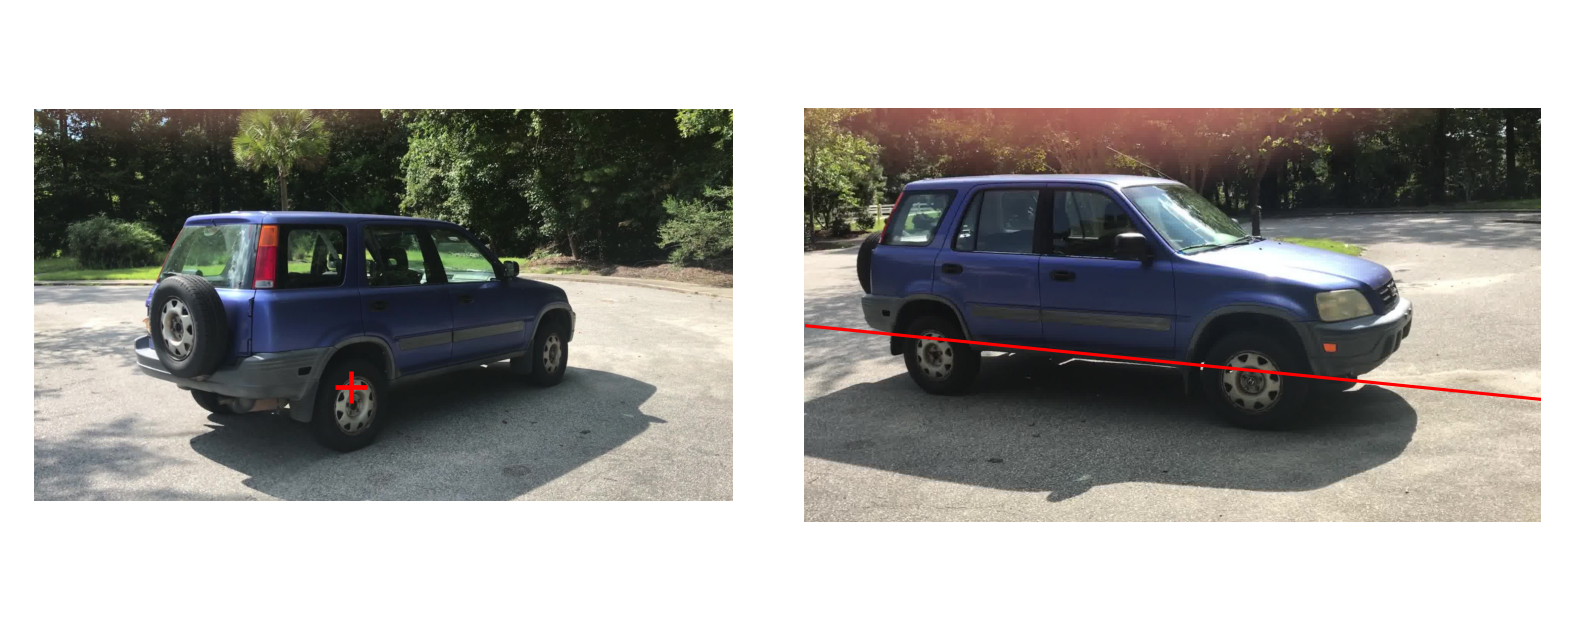

In [7]:
%matplotlib notebook

from matplotlib import patches as pat
import matplotlib.pyplot as plt
from matplotlib import collections

ref_imgs = [I1, I2]

ncols = 2
nrows = 1
size = 3.5
fig = plt.figure(dpi=150, figsize=(ncols*size, nrows*size*.8))
# t = fig.suptitle("Debug")
H, W = ref_imgs[0].shape[0], ref_imgs[1].shape[1]

saxs = [fig.add_subplot(nrows,ncols,i) for i in range(1 , len(ref_imgs)+1)]
paxs = [None for i in range(len(ref_imgs))]
pts = np.zeros((len(ref_imgs), 2)) - 1
selected_idx = None
for ax, i in zip(saxs, ref_imgs):
    ax.imshow(i)
    ax.axis('off')
    ax.patch = ax.add_patch(pat.Rectangle((0,0), W, H, edgecolor='w', lw=0., fill=None))
    
fig.tight_layout()

def add_lines(x, y):
    pixels1 = np.array([[x, y]])
    num_points = pixels1.shape[0]
    F = fundamental_matrix(P1, P2, K1, K2)
    pix_h = np.concatenate([pixels1, np.ones((num_points, 1))], 1)
    epiLines = pix_h @ F.T
    pts = lineToBorderPoints(epiLines, I2.shape)
    lines = np.stack([pts[:, :2], pts[:, 2:]], axis=1)
    collection=collections.LineCollection(lines, linewidths=1.0, colors="red")
    return collection
    

def onclick(event):
    print(event)
    if event.inaxes is not None:
        try:
            idx = saxs.index(event.inaxes)
        except ValueError:
            return
        global selected_idx
        if event.button == 1:
            pax = paxs[idx]
            if pax is not None:
                pax.remove()
            paxs[idx] = event.inaxes.scatter(event.xdata, event.ydata, s=100, c='r', marker='+', vmin=0., vmax=1.)

            idx_other = 1
            pax = paxs[idx_other]
            if pax is not None:
                pax.remove()
            collection = add_lines(event.xdata, event.ydata)
            paxs[idx_other] = collection
            saxs[idx_other].add_collection(collection)
            
            pts[idx, 0] = event.xdata / W
            pts[idx, 1] = event.ydata / H
            print(pts[idx, 0], pts[idx, 1])
        else:
            global selected_idx
            if selected_idx is not None:
                ax = saxs[selected_idx]
                ax.patch.set_edgecolor('w')  
                ax.patch.set_linewidth(0.)
            selected_idx = idx
            saxs[selected_idx].patch.set_edgecolor('g')
            saxs[selected_idx].patch.set_linewidth(1.)

cid = fig.canvas.mpl_connect('button_press_event', onclick)